##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [ ]:
#%pip install pandas 
#%pip install matplotlib
#%pip install scikit-learn
#%pip install imblearn
#%pip install tensorflow
#%pip install keras-tuner -q
#%pip install imbalanced-learn
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [1]:
# Can have as many cells as you want for code
import pandas as pd
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [ ]:
# Hyperparameter tuning

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import math
from sklearn import metrics
import matplotlib.pyplot as plt
import keras_tuner


## Neural Network model

def existing_model(units, dropout, lr):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = units, activation = "relu"))
    if dropout:
        keras.layers.Dropout(0.25)
    model.add(keras.layers.Dense(12, activation = "relu"))
    if dropout:
        keras.layers.Dropout(0.25)
    model.add(keras.layers.Dense(1, activation = "sigmoid"))
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = lr), loss = 'binary_crossentropy', 
                  metrics = ['accuracy', 'F1Score', 'R2Score', keras.metrics.RootMeanSquaredError()])

    return model

## Hyper parameters to be investigated

def build_model(hp):
    units = hp.Int("units", min_value=24, max_value=60, step=4)
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log") 
    model = existing_model(units=units, dropout=dropout, lr=lr)
    return model

tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective=keras_tuner.Objective("val_f1_score", direction = "max"),
    max_trials=3,
    executions_per_trial=3,
    overwrite=True,
    directory="tmp",
    project_name="helloworld"
)


build_model(keras_tuner.HyperParameters())

tuner.search(x_train_new, y_train_new, epochs = 20, validation_data = (x, y))

tuner.results_summary()

In [25]:
# Neural Network

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import math
from sklearn import metrics
import matplotlib.pyplot as plt


def neural_network(x, y):
    units = 44
    lr = 0.0010477328827800908
    dropout = True

    model = keras.Sequential()
    model.add(keras.layers.Dense(units = units, activation = "relu"))
    if dropout:
        keras.layers.Dropout(0.25)
    model.add(keras.layers.Dense(12, activation = "relu"))
    if dropout:
        keras.layers.Dropout(0.25)
    model.add(keras.layers.Dense(1, activation = "sigmoid"))


    model.compile(optimizer = keras.optimizers.Adam(learning_rate = lr), loss = 'binary_crossentropy', 
                      metrics = ['accuracy', 'F1Score', 'R2Score', keras.metrics.RootMeanSquaredError()])

    my_callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor = 'val_f1_score', patience = 1, mode = 'max'), 
        # the learning rate will reduce once the F1Score has plateau-ed on a maximum value after 1 epoch
        keras.callbacks.EarlyStopping(monitor = 'loss', mode = 'min', patience = 5)
        # stops the training once loss is plateau-ed at the minimum
    ] 
    

    model.fit(x, y, epochs = 20)

    y_pred = model.predict(x)
    for i in range(len(y_pred)):
        if y_pred[i][0] < 0.5:
            y_pred[i][0] = 0
        else:
            y_pred[i][0] = 1

#     rmse = math.sqrt(metrics.mean_squared_error(y_pred,y))
#     print(rmse)

#     r2score = metrics.r2_score(y_pred, y)
#     print(r2score)

#     f1score = metrics.f1_score(y_pred, y)
#     print(f1score)

#     confusion_matrix = metrics.confusion_matrix(y, y_pred)
#     cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
#     cm_display.plot()
#     plt.show()

#     print(metrics.classification_report(y, y_pred))
    
    return y_pred




## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [26]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LassoCV
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE


def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    
    df = hidden_data
    
    # Change the min_occ_date
    
    df["min_occ_date"] = pd.to_datetime(df["min_occ_date"],format = "%Y-%m-%d",errors='coerce')
    df["cltdob_fix"] = pd.to_datetime(df["cltdob_fix"],format = "%Y-%m-%d",errors='coerce')

    today = datetime.now()

    df["days_since_first_purchase"] = df["min_occ_date"].transform(lambda x: today-x)
    df["age"] = df["cltdob_fix"].transform(lambda x: today-x)

    df["days_since_first_purchase"] = pd.to_numeric(df['days_since_first_purchase'].dt.days, downcast='integer')
    df["age"] = pd.to_numeric((df['age'].dt.days)/365, downcast='integer')

    df = df.drop(columns=["min_occ_date","cltdob_fix","clntnum"])
    
    # Selection of data
    
    cols = df.columns
    num_cols = df._get_numeric_data().columns

    df["f_purchase_lh"] = df["f_purchase_lh"].fillna(0)
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    cols = df.columns
    num_cols = df.select_dtypes(include=numerics)
    cat_cols = df.select_dtypes(exclude=numerics)
    
    # Imputing and Encoding of data
    
    imputer = KNNImputer(n_neighbors=2)
    num_cols = pd.DataFrame(imputer.fit_transform(num_cols), columns=num_cols.columns)

    le = LabelEncoder()
    for col in cat_cols.columns:
        encoded = le.fit_transform(cat_cols[col])    
        cat_cols[col] = encoded

    df = pd.concat([num_cols.reset_index(drop=True), cat_cols.reset_index(drop=True)], axis=1)
    df = df.dropna(thresh=303)
    
    # Defining of input and output dataframes
    
    x = df.drop(columns=["f_purchase_lh"])

    y = df["f_purchase_lh"]
    
    # Training 80%, test 20%

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    ## Perform downsampling first on majority
    x_train = pd.DataFrame(x_train)
    y_train = pd.DataFrame(y_train)

    one_indices = y_train[y_train["f_purchase_lh"]==1].index
    one = len(y_train[y_train["f_purchase_lh"]==1])

    zero_indices = y_train[y_train["f_purchase_lh"]==0].index
    zero = len(y_train[y_train["f_purchase_lh"]==0])

    random_indices = np.random.choice(zero_indices, zero - 3000 , replace=False)

    down_sample_indices = np.concatenate([one_indices,random_indices])

    x_train_new = x_train.loc[down_sample_indices]
    y_train_new = y_train.loc[down_sample_indices]["f_purchase_lh"]


    ## Now do SMOTE on minority

    x_train_new, y_train_new = SMOTE().fit_resample(x_train_new, y_train_new)


    ## Normalise data
    scaler = StandardScaler().fit(x_train_new)
    x_train_new = scaler.transform(x_train_new)
    x_test = scaler.transform(x_test)
    x = scaler.transform(x)

    result = neural_network(x, y)
#   print(sum(result))
    return result

##### Cell to check testing_hidden_data function

Epoch 1/20
563/563 [==============================] - 1s 1ms/step - loss: 0.1609 - accuracy: 0.9544 - f1_score: 0.0759 - r2_score: -0.0673 - root_mean_squared_error: 0.2011
Epoch 2/20
563/563 [==============================] - 1s 1ms/step - loss: 0.1347 - accuracy: 0.9604 - f1_score: 0.0759 - r2_score: 0.0990 - root_mean_squared_error: 0.1848
Epoch 3/20
563/563 [==============================] - 1s 1ms/step - loss: 0.1266 - accuracy: 0.9609 - f1_score: 0.0759 - r2_score: 0.1442 - root_mean_squared_error: 0.1801
Epoch 4/20
563/563 [==============================] - 1s 1ms/step - loss: 0.1210 - accuracy: 0.9623 - f1_score: 0.0759 - r2_score: 0.1813 - root_mean_squared_error: 0.1762
Epoch 5/20
563/563 [==============================] - 1s 1ms/step - loss: 0.1131 - accuracy: 0.9645 - f1_score: 0.0759 - r2_score: 0.2292 - root_mean_squared_error: 0.1709
Epoch 6/20
563/563 [==============================] - 1s 996us/step - loss: 0.1099 - accuracy: 0.9659 - f1_score: 0.0759 - r2_score: 0.2557

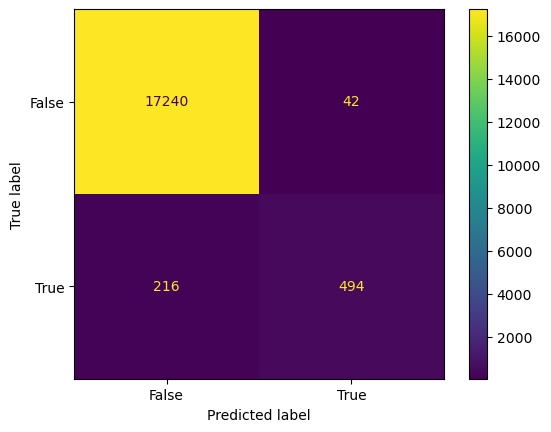

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     17282
         1.0       0.92      0.70      0.79       710

    accuracy                           0.99     17992
   macro avg       0.95      0.85      0.89     17992
weighted avg       0.99      0.99      0.98     17992

[536.]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
Epoch 1/20
563/563 [==============================] - 1s 966us/step - loss: 0.1521 - accuracy: 0.9596 - f1_score: 0.0759 - r2_score: 0.0308 - root_mean_squared_error: 0.1917
Epoch 2/20
563/563 [==============================] - 1s 968us/step - loss: 0.1339 - accuracy: 0.9605 - f1_score: 0.0759 - r2_score: 0.1097 - root_mean_squared_error: 0.1837
Epoch 3/20
563/563 [==============================] - 1s 1ms/step - loss: 0.1250 - accuracy: 0.9619 - f1_score: 0.0759 - r2_score: 0.1546 - root_mean_squared_error: 0.1790
Epoch 4/20
563/563 [==============================] - 1s 1ms/step - loss: 0.1194 - accuracy: 0.9627 - f1

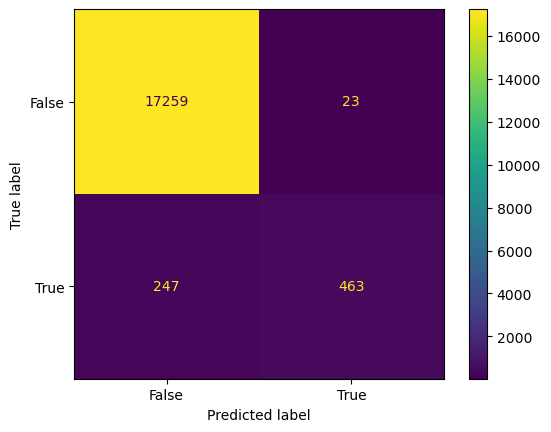

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     17282
         1.0       0.95      0.65      0.77       710

    accuracy                           0.98     17992
   macro avg       0.97      0.83      0.88     17992
weighted avg       0.98      0.98      0.98     17992

[486.]
[486.]


In [27]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
# test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!